In [15]:
!pip install tensorflow

     |████████████████████████████████| 588.3 MB 72 kB/s  eta 0:00:016    |███▍                            | 61.8 MB 7.0 MB/s eta 0:01:15     |██████▍                         | 117.7 MB 8.4 MB/s eta 0:00:57     |████████▏                       | 149.2 MB 15.2 MB/s eta 0:00:29     |██████████                      | 184.6 MB 21.0 MB/s eta 0:00:20
     |████████████████████████████████| 21.5 MB 8.5 MB/s eta 0:00:011
     |████████████████████████████████| 57 kB 14.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 16.0 MB/s eta 0:00:01
     |████████████████████████████████| 439 kB 11.0 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 19.3 MB/s eta 0:00:01
     |████████████████████████████████| 4.8 MB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 18.3 MB/s eta 0:00:01
     |████████████████████████████████| 177 kB 17.4 MB/s eta 0:00:01
     |██████████████████████████

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from helper_functions import compute_cum_tracking_cost
from mlp_jax import MLP
from generate_data import load_object
from model_learning import TrajDataset, train_model, eval_model, numpy_collate, save_checkpoint, restore_checkpoint

/home/anusha/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/anusha/.local/lib/python3.8/site-packages/jax/_src/api_util.py:165: SyntaxWarning: Jitted function has static_argnums=(0, 1, 9), but only accepts 8 positional arguments. This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has {argnums_name}={argnums}, "
2023-01-22 19:25:14.519992: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/anusha/Research/ws_kr/devel/lib:/opt/ros/noetic/lib
2023-01-22 19:25:14.520151: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not

## Load data

In [3]:
import numpy as np

file_path = r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/uni_train-10.pkl"
unicycle_data = load_object(file_path)

actual_traj = np.vstack(unicycle_data[0])
ref_traj = np.vstack(unicycle_data[1])
print(actual_traj.shape)
print(ref_traj.shape)

(5454, 3)
(5400, 6)


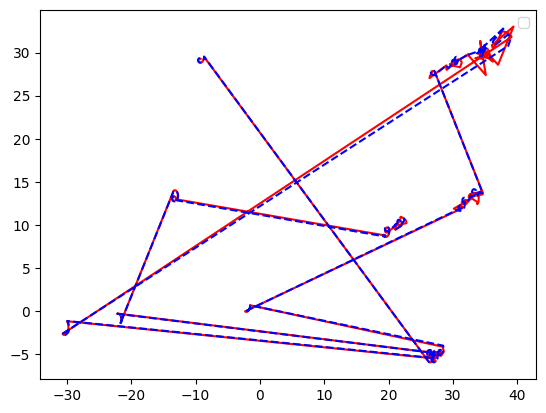

In [14]:
import matplotlib.pyplot as plt

plt.plot(ref_traj[0:1000, 0], ref_traj[0:1000, 1], 'r-', 
         actual_traj[0:1000, 0], actual_traj[0:1000, 1], 'b--')
plt.legend()

## Prepare data with augmented states and compute cost

In [15]:
import jax

N = 5
q = 2
p = 3 + 3*N
traj_len = ref_traj.shape[0]

ref_chunks = np.vstack([ref_traj[i*100+5:(i+1)*100-5, :] for i in range(0, len(ref_traj))])
actual_chunks = np.vstack([actual_traj[i*101+5:(i+1)*101-6, :] for i in range(0, len(actual_traj))])


Kp = np.array([[2, 0, 0], [0, 1, 0]])
key = jax.random.PRNGKey(793)
Kd = jax.random.uniform(key, shape=(2, 3))

cost_traj, input_traj = compute_cum_tracking_cost(ref_chunks, actual_chunks, Kp, Kd, N)

aug_state = [np.append(actual_chunks[r, :], ref_chunks[r:r+N, :3]) for r in range(len(ref_chunks)-N)]
aug_state = np.array(aug_state)

Tstart=0
Tend=1000

dataset = TrajDataset(aug_state[Tstart:Tend-1, :].astype('float64'), input_traj[Tstart:Tend-1, :].astype('float64'),
                               cost_traj[Tstart:Tend-1, None].astype('float64'), aug_state[Tstart+1:Tend, :].astype('float64'))

## Add noise to the ref traj

In [ ]:
noise = np.random.normal()

## Define model parameters and train

In [16]:
# Load model parameters using yaml file
import ruamel.yaml as yaml

with open(r"/home/anusha/Research/Layered-architecture-quadrotor-control/Simulations/data/params.yaml") as f:
        yaml_data = yaml.load(f, Loader=yaml.RoundTripLoader)

num_hidden = yaml_data['num_hidden']
batch_size = yaml_data['batch_size']
learning_rate = yaml_data['learning_rate']
num_epochs = yaml_data['num_epochs']
model_save = yaml_data['save_path']

In [17]:
model = MLP(num_hidden=num_hidden, num_outputs=1)
# Printing the model shows its attributes
print(model)

MLP(
    # attributes
    num_hidden = [500, 400, 200]
    num_outputs = 1
)


In [18]:
rng = jax.random.PRNGKey(427)
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (batch_size, p))  # Batch size 32, input size p
# Initialize the model
params = model.init(init_rng, inp)

In [9]:
# Run only if error in next cell
try:
    import optax
except ModuleNotFoundError: 
    !pip install --quiet optax
    import optax 

In [19]:
import optax # Run previous cell if optax not found
# Input to the optimizer are optimizer settings like learning rate
optimizer = optax.adam(learning_rate=learning_rate)

In [20]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

In [21]:
import torch.utils.data as data

train_data_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=numpy_collate)
trained_model_state = train_model(model_state, train_data_loader, num_epochs=num_epochs)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>


100%|███████████████████████████████████████| 1000/1000 [00:20<00:00, 48.53it/s]


In [22]:
eval_model(trained_model_state, train_data_loader, batch_size)

Loss of the model: 0.12


In [23]:
trained_model = model.bind(trained_model_state.params)

In [24]:
# Save model - issue comes from tensorflow requiring installation - need to fix
save_checkpoint(trained_model_state, model_save, 9)

In [25]:
%matplotlib notebook

<IPython.core.display.Javascript object>


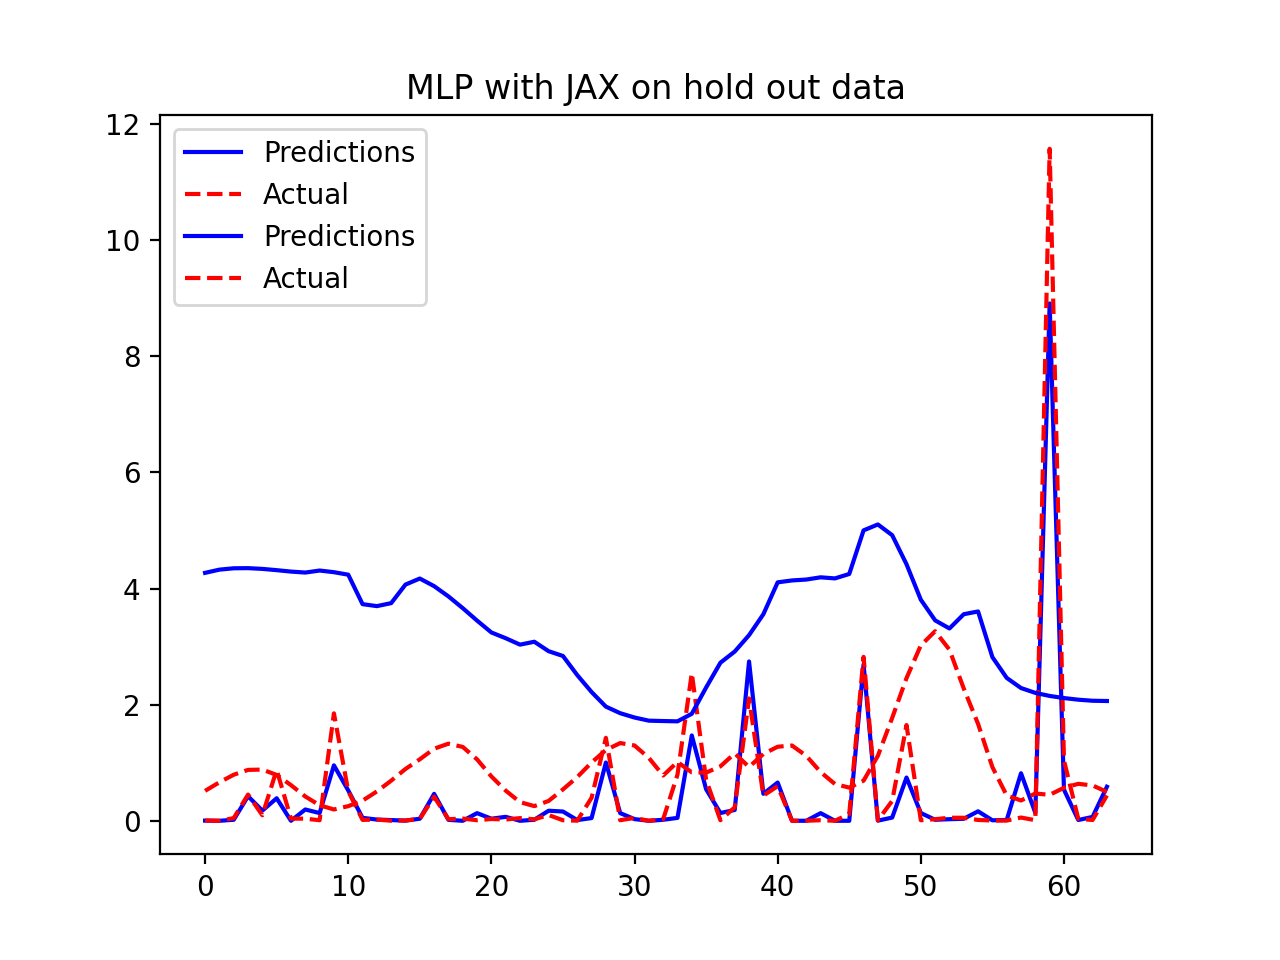

Text(0.5, 1.0, 'MLP with JAX on training data')

In [26]:
import matplotlib.pyplot as plt

data_input, _, cost, _ = next(iter(train_data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
plt.plot(out.ravel(), 'b-', label="Predictions")
plt.plot(cost.ravel(), 'r--', label="Actual")
plt.legend()
plt.title("MLP with JAX on training data")

## Inference 

In [27]:
Tstart=2800
Tend=4000

test_dataset = TrajDataset(aug_state[Tstart:Tend-1, :].astype('float64'), input_traj[Tstart:Tend-1, :].astype('float64'),
                               cost_traj[Tstart:Tend-1, None].astype('float64'), aug_state[Tstart+1:Tend, :].astype('float64'))
test_data_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=numpy_collate)
eval_model(trained_model_state, test_data_loader, batch_size)

data_input, _, cost, _ = next(iter(test_data_loader))
out = trained_model(data_input)  # No explicit parameter passing necessary anymore
plt.plot(out.ravel(), 'b-', label="Predictions")
plt.plot(cost.ravel(), 'r--', label="Actual")
plt.legend()
plt.title("MLP with JAX on hold out data")

Loss of the model: 54.03


Text(0.5, 1.0, 'MLP with JAX on hold out data')

## Test time

In [37]:
from model_learning import test_model

data_state, _, data_cost, _ = next(iter(test_data_loader))
print(data_state[0])
print(data_cost[0])
solution, data = test_model(trained_model_state, test_data_loader, batch_size)

[-13.08920765 -25.91962814  11.53871059 -13.19780922 -25.7375679
  11.53871059 -13.29124355 -25.61016464  11.1503973  -13.34361267
 -25.4968338   10.80459881 -13.3655901  -25.40010262  10.47875786
 -13.36009598 -25.32321548  10.16390324]
[[0.5156731]]


init [-13.089208 -25.919628  11.53871 ]
New ref [[-13.089208  -25.919628   11.53871  ]
 [-14.800244   -7.56273    12.420445 ]
 [ -7.8456197 -40.676888    9.226724 ]
 [ -9.308083  -30.734592   20.321642 ]
 [ -7.423736  -30.607117  -11.811272 ]]
rollout [[-13.08920765 -25.91962814  11.53870964]
 [  0.          -0.           0.        ]
 [-32.23831853  -0.         -54.75124617]
 [ -3.37468425  14.63522557 -13.43349886]
 [ -5.74912301   6.77500637 -17.43527286]]
init [-13.126629 -25.817444  11.150396]
New ref [[-13.126629  -25.817444   11.150396 ]
 [-15.938839   -7.7903695  11.714557 ]
 [ -7.3031883 -40.972977    8.598593 ]
 [ -9.094845  -29.510912   19.657959 ]
 [ -9.187018  -30.073112  -12.26547  ]]
rollout [[-13.12662888 -25.81744385  11.15039635]
 [  0.          -0.           0.        ]
 [-27.05063754  -0.         -43.36731432]
 [ 80.19599428  56.64738084 131.35157502]
 [ -8.27626744   5.60537559 -20.51450611]]
init [-13.125087 -25.728687  10.804594]
New ref [[-13.125087  -25.728687  

rollout [[-14.00325775 -30.37921333 -16.82276154]
 [ -0.           0.           0.        ]
 [ 14.73811395   0.          35.65506766]
 [ -1.49756011  -2.92458759   2.32832551]
 [  7.2395351   -7.65473056  -2.34528174]]
init [-13.980764 -30.850618 -17.608198]
New ref [[-13.980764 -30.850618 -17.608198]
 [-13.16758  -28.575874 -28.880615]
 [-16.976099 -36.44511  -25.79119 ]
 [-10.132342 -23.735502 -19.690826]
 [-16.554516 -22.985271 -18.339684]]
rollout [[-13.98076439 -30.85061836 -17.60819817]
 [  0.           0.           0.        ]
 [ 14.11145008   0.          34.82161185]
 [ -3.17161032  -0.85763081  -1.0240401 ]
 [ -7.01754299  11.52966726 -29.86130632]]
init [-15.2213745 -31.602974  -20.509253 ]
New ref [[-15.2213745 -31.602974  -20.509253 ]
 [-14.524982  -28.304296  -30.267525 ]
 [-14.471398  -38.28997   -26.881655 ]
 [ -9.128522  -23.421862  -19.208414 ]
 [-17.123983  -21.005753  -18.192093 ]]
rollout [[-15.22137451 -31.60297394 -20.50925255]
 [ -0.          -0.           0.    

<IPython.core.display.Javascript object>


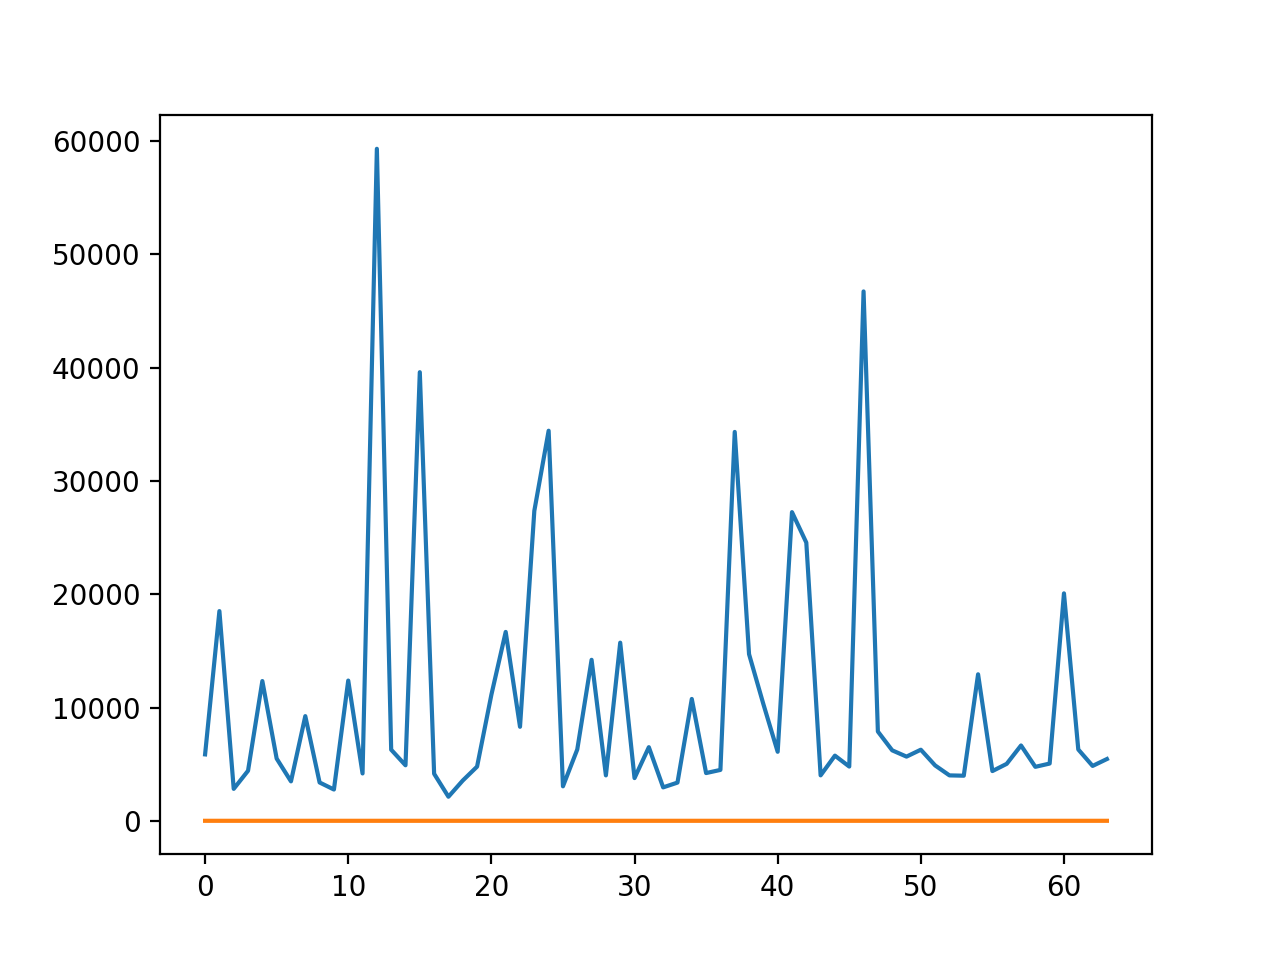

In [38]:
# How to parse the solution at test time?
from helper_functions import forward_simulate

N = 5
cost = []
reg_cost = []
rollout = []
ref = []

i = 0
for sol in solution:
    # Take the augmented state -- init state + ref and simulate the unicycle -- compute cost and verify
    reg_cost.append(sol.fun)
    new_aug_state = sol.x
    x0 = new_aug_state[0:3]
    print("init", x0)
    ref.append(new_aug_state.reshape([N, 3]))
    print("New ref", ref[i])
    # input
    c, x = forward_simulate(x0, ref[i], Kp, Kd, N)
    cost.append(c)
    rollout.append(x)
    print("rollout", x)
    i += 1
    
plt.figure()
plt.plot(cost)
plt.plot(reg_cost)

<IPython.core.display.Javascript object>


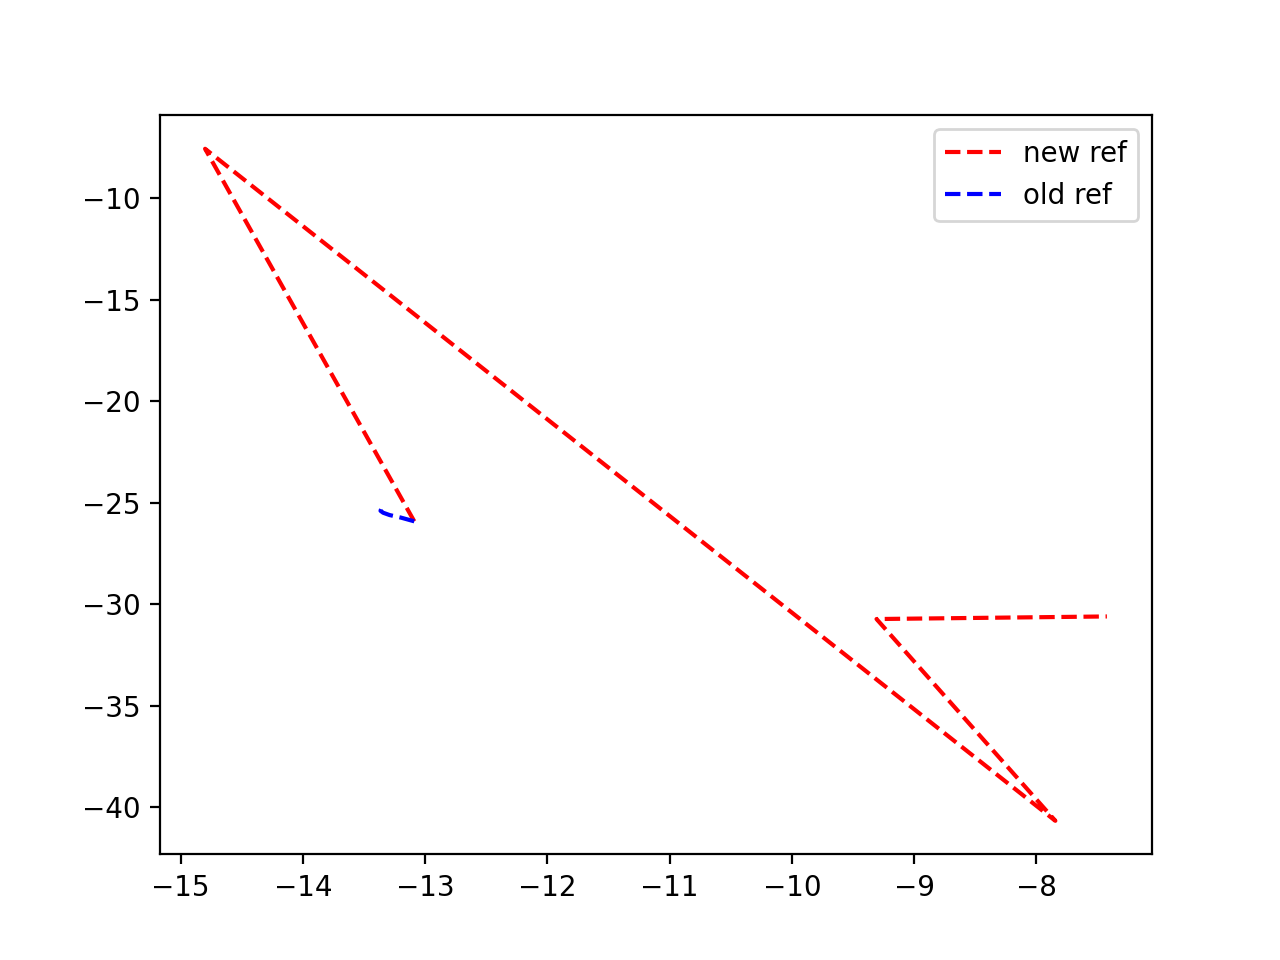

[[-13.089208  -25.919628   11.53871  ]
 [-14.800244   -7.56273    12.420445 ]
 [ -7.8456197 -40.676888    9.226724 ]
 [ -9.308083  -30.734592   20.321642 ]
 [ -7.423736  -30.607117  -11.811272 ]]
[-13.08920765 -25.91962814  11.53871059 -13.19780922 -25.7375679
  11.53871059 -13.29124355 -25.61016464  11.1503973  -13.34361267
 -25.4968338   10.80459881 -13.3655901  -25.40010262  10.47875786
 -13.36009598 -25.32321548  10.16390324]


In [39]:
plt.figure()
print(ref[0])
print(data[0])
plt.plot(ref[0][:, 0], ref[0][:, 1], 'r--', label="new ref")
plt.plot(data[0][0::3], data[0][1::3], 'b--', label="old ref")
plt.legend()

In [36]:
print(solution[0].fun)

0.42536685
